In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

seed = 222
np.random.seed(seed)
### import data
df = pd.read_csv('input.csv')
### training and test set
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

def get_train_test(test_size=0.95):
    """
    split data into train and test sets
    """
    y = 1 * (df.cand_pty_affiliation == 'REP')
    X = df.drop(['cand_pty_affiliation'], axis=1)
    X = pd.get_dummies(X, sparse =True)
    X.drop(X.columns[X.std() == 0], axis=1, inplace=True)
    return train_test_split(X, y, test_size=test_size, random_state=seed)

xtrain, xtest, ytrain, ytest = get_train_test()

df.head()

,cand_pty_affiliation,cand_office_st,cand_office,cand_status,rpt_tp,transaction_tp,entity_tp,state,classification,cycle,transaction_amt
0,REP,US,P,C,Q3,15,IND,NY,Engineer,2016.0,500.0
1,DEM,US,P,C,M5,15E,IND,OR,Math-Stat,2016.0,50.0
2,DEM,US,P,C,M3,15,IND,TX,Scientist,2008.0,250.0
3,DEM,US,P,C,Q2,15E,IND,IN,Math-Stat,2016.0,250.0
4,REP,US,P,C,12G,15,IND,MA,Engineer,2016.0,184.0


In [4]:
xtrain.shape

(5000, 158)

In [5]:
df.shape

(100000, 11)

In [6]:
xtest.shape

(95000, 158)

In [7]:
xtrain.head()

,cycle,transaction_amt,cand_office_st_AK,cand_office_st_AL,cand_office_st_AR,cand_office_st_AZ,cand_office_st_CA,cand_office_st_CO,cand_office_st_CT,cand_office_st_DC,...,state_VI,state_VT,state_WA,state_WI,state_WV,state_WY,state_ZZ,classification_Engineer,classification_Math-Stat,classification_Scientist
34018,2008.0,250.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
52563,2012.0,200.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
26117,2008.0,250.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
66112,2012.0,250.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
33433,2010.0,1000.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


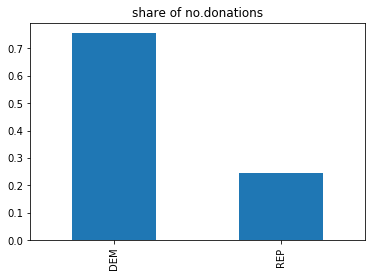

In [14]:
df.cand_pty_affiliation.value_counts(normalize=True).plot(kind='bar', title='share of no.donations')
plt.show()

In [25]:
import pydotplus
from IPython.display import Image
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

def print_graph(clf, feature_names):
    """print decision tree"""
    graph = export_graphviz(clf, label='root',proportion=True,impurity=False,out_file=None,
                            feature_names=feature_names,class_names={0:'D', 1:'R'}, filled=True,rounded=True)
    graph = pydotplus.graph_from_dot_data(graph)
    return Image(graph.create_png())


In [26]:
t1 = DecisionTreeClassifier(max_depth=1, random_state=seed)
t1.fit(xtrain, ytrain)
p = t1.predict_proba(xtest)[:, 1]

decision tree roc-auc score: 0.672


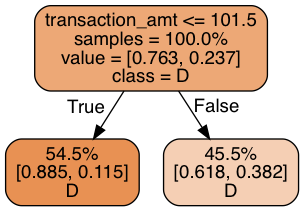

In [28]:
print('decision tree roc-auc score: %.3f' %roc_auc_score(ytest, p))
print_graph(t1, xtrain.columns)

decision tree roc-auc score: 0.751


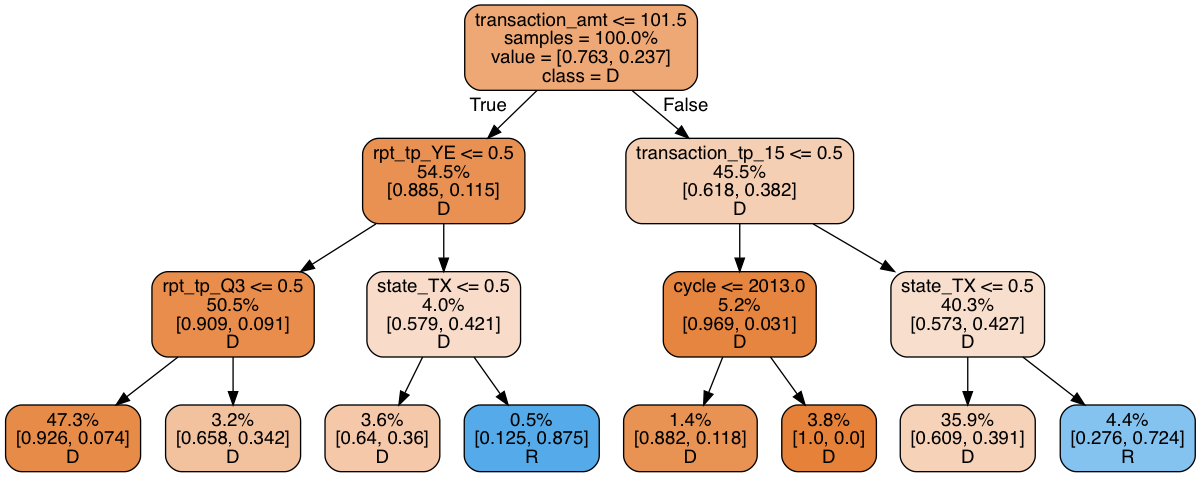

In [43]:
t2 = DecisionTreeClassifier(max_depth=3, random_state=seed)
t2.fit(xtrain, ytrain)
p = t2.predict_proba(xtest)[:, 1]
print('decision tree roc-auc score: %.3f' %roc_auc_score(ytest, p))
print_graph(t2, xtrain.columns)

decision tree roc-auc score: 0.740


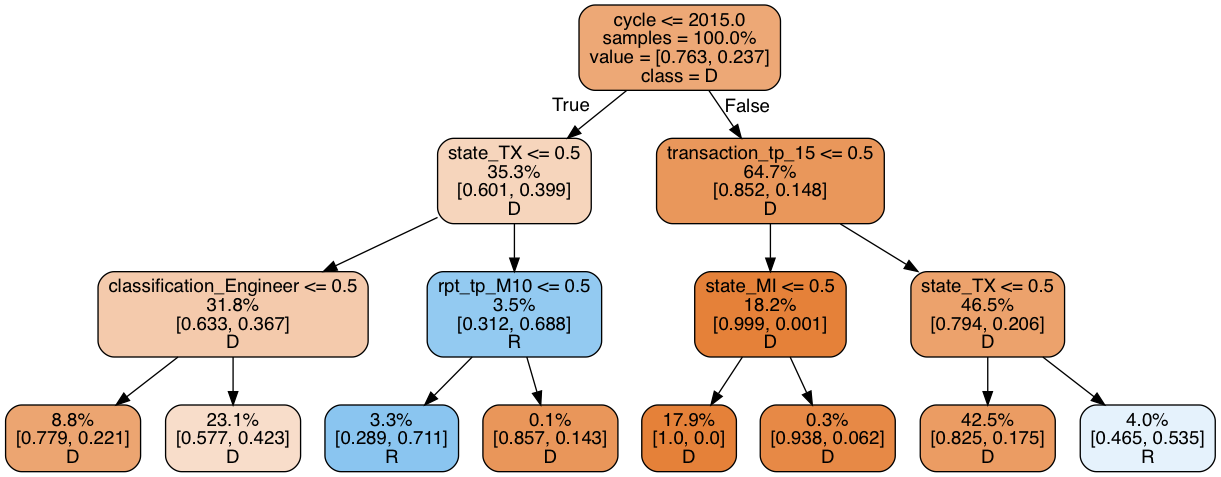

In [39]:
drop = ['transaction_amt']

xtrain_slim = xtrain.drop(drop, 1)
xtest_slim = xtest.drop(drop, 1)
t3 = DecisionTreeClassifier(max_depth=3, random_state=seed)
t3.fit(xtrain_slim, ytrain)
p = t3.predict_proba(xtest_slim)[:, 1]
print('decision tree roc-auc score: %.3f' %roc_auc_score(ytest, p))
print_graph(t3, xtrain_slim.columns)

In [41]:
p1 = t2.predict_proba(xtest)[:, 1]
p2 = t3.predict_proba(xtest_slim)[:, 1]

pd.DataFrame({'full_data': p1, 'red_data': p2}).corr()

,full_data,red_data
full_data,1.000000,0.669128
red_data,0.669128,1.000000


In [53]:
p1 = t2.predict_proba(xtest)[:, 1]
p2 = t3.predict_proba(xtest_slim)[:, 1]
p = np.mean([p1, p2], axis=0)
print('average of decision tree roc-auc score: %.3f' % roc_auc_score(ytest, p))

average of decision tree roc-auc score: 0.783


In [67]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=seed,max_depth=14)

rf.fit(xtrain, ytrain)
p = rf.predict_proba(xtest)[:, 1]
print('average of decision tree roc-auc score: %.3f' % roc_auc_score(ytest, p))

average of decision tree roc-auc score: 0.849


In [68]:
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline



In [72]:
def get_models():
    nb = GaussianNB()
    svc = SVC(C=100, probability=True)
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=100, random_state=seed)
    nn = MLPClassifier((80, 10), early_stopping=False, random_state=seed)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=seed)
    rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=seed)
    
    models = {
        'svm': svc,
        'knn': knn,
        'mlp-nn': nn,
        'naive bayes': nb,
        'random forest': rf,
        'gbm': gb,
        'logistic': lr,
    }
    return models

def train_predict(model_list):
    """fit models in list on training set and return preds"""
    
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)
    
    print('Fitting models.')
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print('%s...'%name, end=' ', flush=False)
        m.fit(xtrain, ytrain)
        P.iloc[:, i] = m.predict_proba(xtest)[:,1]
        cols.append(name)
        print('done~')
    
    P.columns = cols
    print('Done,\n')
    return P


def score_models(P, y):
    """score model in prediction DF"""
    print('Scoring models.')
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:,m])
        print('%-26s: %.3f' %(m, score))
        
    print('Done~.\n')


In [73]:
models = get_models()
P = train_predict(models)
score_models(P, ytest)

Fitting models.
svm... done~
knn... done~
mlp-nn... done~
random forest... done~
gbm... done~
logistic... done~
Done,

Scoring models.
svm                       : 0.850
knn                       : 0.779
mlp-nn                    : 0.851
random forest             : 0.844
gbm                       : 0.878
logistic                  : 0.854
Done~.



[MLENS] backend: threading


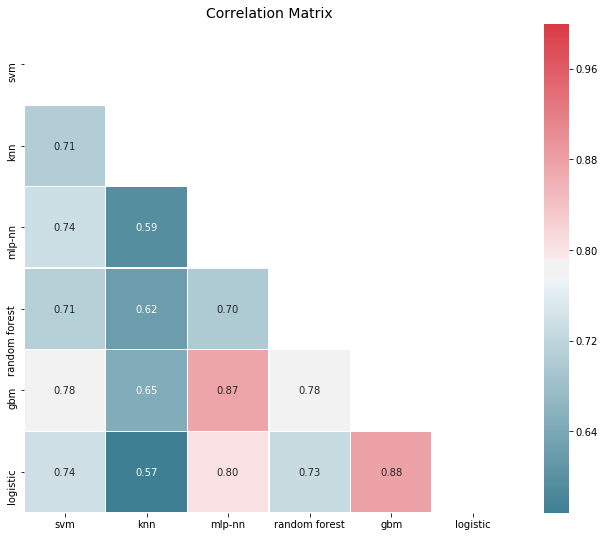

In [75]:
from mlens.visualization import corrmat

corrmat(P.corr(), inflate=False)
plt.show()